In [3]:
import pickle
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import time


In [4]:
import sys
import os
sys.path.insert(0, './../scripts')

In [13]:
from importlib import reload
from tqdm import tqdm
import functions as fun

import ricciardi_class as ric
import network as network

output_dir='./../Paper_Figures'

In [6]:
reload(ric)

ri = ric.Ricciardi()
ri.set_up_nonlinearity('phi_int')

ri_nosat = ric.Ricciardi()
ri_nosat.tau_rp = 0
ri_nosat.set_up_nonlinearity('phi_int_nosat')

Loading previously saved nonlinearity
Loading previously saved nonlinearity


In [7]:
def phi_relu(mu):
    a_relu = 1.5
    return a_relu*np.fmax(mu*1e3,0)

def phi_ssn(mu):
    a_ssn = 0.05
    return a_ssn*np.fmax(mu*1e3,0)**2



In [8]:
a=phi_relu

# Plot Everything Together

Text(0.5, 1.0, 'Inhibitory')

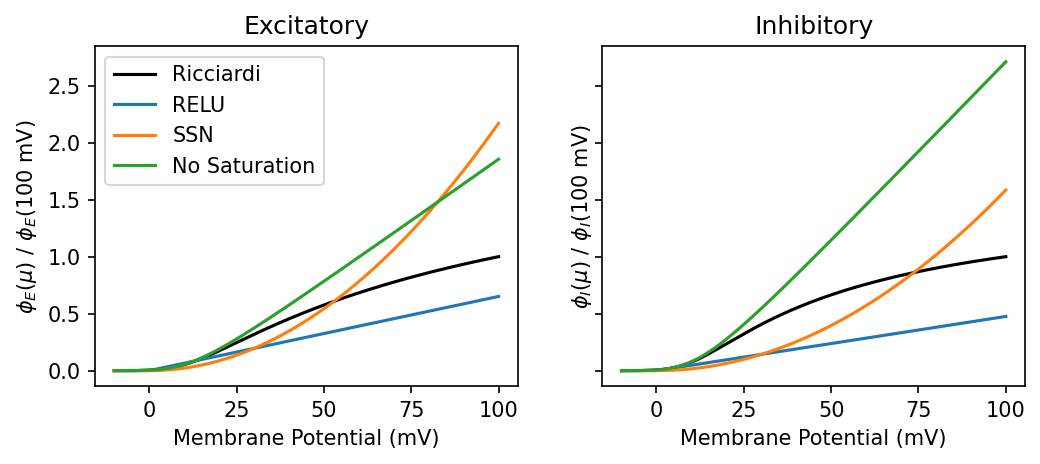

In [9]:
fig,axs = plt.subplots(1,2,figsize=(8,3),dpi=150,sharex=True,sharey=True)
mus = np.linspace(-0.01,0.1,1100+1)

axs[0].plot(1e3*mus,ri.phi_int_E(mus)/ri.phi_int_E(mus[-1]),'k',label='Ricciardi')
axs[0].plot(1e3*mus,phi_relu(mus)/ri.phi_int_E(mus[-1]),label='RELU')
axs[0].plot(1e3*mus,phi_ssn(mus)/ri.phi_int_E(mus[-1]),label='SSN')
axs[0].plot(1e3*mus,ri_nosat.phi_int_E(mus)/ri.phi_int_E(mus[-1]),label='No Saturation')

axs[1].plot(1e3*mus,ri.phi_int_I(mus)/ri.phi_int_I(mus[-1]),'k',label='Ricciardi')
axs[1].plot(1e3*mus,phi_relu(mus)/ri.phi_int_I(mus[-1]),label='RELU')
axs[1].plot(1e3*mus,phi_ssn(mus)/ri.phi_int_I(mus[-1]),label='SSN')
axs[1].plot(1e3*mus,ri_nosat.phi_int_I(mus)/ri.phi_int_I(mus[-1]),label='No Saturation')

axs[0].legend()

axs[0].set_xlabel('Membrane Potential (mV)')
axs[1].set_xlabel('Membrane Potential (mV)')

axs[0].set_ylabel(r'$\phi_E(\mu)\ /\ \phi_E($100 mV)')
axs[1].set_ylabel(r'$\phi_I(\mu)\ /\ \phi_I($100 mV)')

axs[0].set_title('Excitatory')
axs[1].set_title('Inhibitory')

# Set up parameters

In [10]:
sigma_t=0.01; # Input noise, determine how smooth the single neuron transfer function is 
tau_rp=0.002; # Refractory period
K=500; # average number of E connections per neuron (I connections are 1/4 of that)
Tmax_over_tau_E=100;
p=0.1; # probability of connection between cells. 
Lambda=1*10**-3; # mean opsin expression in Volt

N=int(K/p);
N_E,N_I=N,int(N*fun.gamma);
N_X=N_E+N_I

g_E=8#np.random.rand()*7+3
g_I=3#np.random.rand()*(g_E-2.5)+2
beta=1#10**(np.random.rand()*2-1)
sigma_Lambda_over_Lambda=1#10**(np.random.rand()*2-1)
J=0.0004#10**(np.random.rand()*2-5)
r_X=10**(np.linspace(0.1,2,10))
ell=20#5*10**(np.random.rand()*2-1)

L=[0,ell];
sigma_Lambda=sigma_Lambda_over_Lambda*Lambda
# In what follows, I compute W_{AB} starting from the parameters defined above
G_E,G_I=1.0,2.0 # Gain of Excitatory and inhibitory cells and I cells
w_EE=1;w_IE=w_EE/beta;
w_EI=g_E*w_EE;w_II=g_I*w_IE;
w_EX,w_IX=(G_I*fun.gamma*g_E-G_E)*w_EE,(G_I*fun.gamma*g_I-G_E)*w_IE; 
w_X=np.asarray([w_EX,w_IX]);
w=np.zeros((2,2));
w[0,:]=w_EE,-w_EI
w[1,:]=w_IE,-w_II
T=np.arange(0,Tmax_over_tau_E*fun.tau_E,fun.tau_I/3);
mask_time=T>(10*fun.tau_E)
CV_K=(1-p)/np.sqrt(K) 


In [11]:
4*5*10

200

In [14]:
# Generate simulations
print('Computing and saving network response')
n_rates=4
n_Js=2

################## Define vectors that we iterate over

print("You are checking why SSN diverges")
r_X=np.array([100]) # 10**(np.linspace(0.1,2,n_rates))
J= np.array([0.00197932]) #np.exp(np.linspace(-9,-5.3,n_Js))

fun_vecs_E=[phi_ssn]#[phi_relu,phi_ssn,ri_nosat.phi_int_E,ri.phi_int_E]
fun_vecs_I=[phi_ssn]#[phi_relu,phi_ssn,ri_nosat.phi_int_I,ri.phi_int_I]

################## Initialize

RATES=-1*np.ones((len(fun_vecs_E),len(J),len(r_X),len(L),N_E+N_I))
moments_of_r_sim=np.zeros((5,len(fun_vecs_E),len(J),len(r_X)))


################## Loop over function 
for idx_funcs in range(len(fun_vecs_E)):
    func_E=fun_vecs_E[idx_funcs]
    func_I=fun_vecs_I[idx_funcs]


    ################## Loop over J
    for idx_J in range(len(J)):
        ################## Generate disorder

        M,mu_X_over_r_X_tau,Lambda_i,N_E,N_I=fun.Generate_quenched_disorder(CV_K,J[idx_J],K,w,w_X,p,Lambda,sigma_Lambda)

        for idx_r_X in tqdm(range(len(r_X))):

            #------------------------------------------------
            for idx_L in range(len(L)):
                r_X_local,L_local=r_X[idx_r_X],L[idx_L];
        #         print((idx_r_X+1)/len(r_X),(idx_L+1)/len(L))
                DYNA, MUS,Lambda_i_L=fun.High_dimensional_dynamics(T,L_local,r_X_local,M,mu_X_over_r_X_tau,Lambda_i,N_E,N_I,func_E,func_I);
                RATES[idx_funcs,idx_J,idx_r_X,idx_L,:]=np.mean(DYNA,axis=1)
            #------------------------------------------------

            mask_active_cells=(RATES[idx_funcs,idx_J,idx_r_X,1,:]>=0)|(RATES[idx_funcs,idx_J,idx_r_X,0,:]>=0)
            Base_Sim=RATES[idx_funcs,idx_J,idx_r_X,0,:][mask_active_cells]
            Delta_Sim=(RATES[idx_funcs,idx_J,idx_r_X,1,:]-RATES[idx_funcs,idx_J,idx_r_X,0,:])[mask_active_cells]

            moments_of_r_sim[0,idx_funcs,idx_J,idx_r_X]=np.mean(Base_Sim)
            moments_of_r_sim[1,idx_funcs,idx_J,idx_r_X]=np.mean(Delta_Sim)
            moments_of_r_sim[2,idx_funcs,idx_J,idx_r_X]=np.std(Base_Sim)
            moments_of_r_sim[3,idx_funcs,idx_J,idx_r_X]=np.std(Delta_Sim)
            moments_of_r_sim[4,idx_funcs,idx_J,idx_r_X]=np.cov(Base_Sim,Delta_Sim)[0,1]/(np.std(Delta_Sim)**2)

            
dictout={}            
dictout["moments_of_r_sim"]=moments_of_r_sim
dictout["RATES"]=RATES
dictout["r_X"]=r_X
dictout["J"]=J

# nameout='FigureS1_nrep='+str(nrep)
# with open(nameout+'.pkl', 'wb') as handle:
#     pickle.dump(dictout, handle, protocol=pickle.HIGHEST_PROTOCOL)           
            

Computing and saving network response
You are checking why SSN diverges


100%|██████████| 1/1 [02:45<00:00, 165.93s/it]


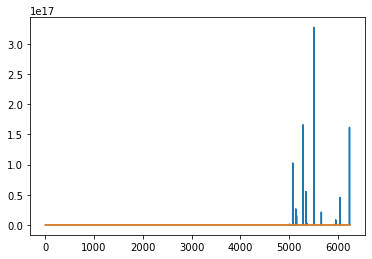

In [19]:
plt.plot(RATES[0,0,0,:,:].T);

# Plot moments Vs Rates

In [ ]:

rows=3;cols=len(fun_vecs_E);
fig, axs = plt.subplots(rows,cols, figsize=(2*cols,2.*rows), facecolor='w', edgecolor='k',squeeze=False,sharey='row',sharex='col')
fig.subplots_adjust(hspace = .1, wspace=.1)

for idx_funcs in range(len(fun_vecs_E)):

    axs[0,idx_funcs].loglog(r_X,moments_of_r_sim[1,idx_funcs,:,:].T, marker='o',label=J)
    axs[0,idx_funcs].set_label(J)

    axs[1,idx_funcs].loglog(r_X,moments_of_r_sim[3,idx_funcs,:,:].T, marker='o',label='std')

    axs[1,idx_funcs].set_label(J)

    axs[2,idx_funcs].plot(r_X,moments_of_r_sim[4,idx_funcs,:,:].T,marker='o',label='std')
    axs[2,idx_funcs].set_xlabel('$r_X (spk/s)$')
    axs[2,idx_funcs].set_label(J)
    
axs[0,0].set_ylabel('$\delta r$ (spk/s)')
axs[1,0].set_ylabel('$\sigma_{\delta r}$ (spk/s)')
axs[2,0].set_ylabel('$rho$ ')

fig.set_size_inches(2.5*cols,2.*rows)

fig.tight_layout()
fig.savefig(nameout+'.pdf', bbox_inches='tight')


In [ ]:
jobname="send_cluster_FigureS1"+"-nrep-{:d} -rX {:.2f} -J {:.2f} ".format(1, 0.22344, 0.3456)
jobname